# Flight Condition Normalization 

Following the ideas from: [Remaining Useful Life Prediction of Aircraft Engines with Variable Length Input Sequences](https://papers.phmsociety.org/index.php/phmconf/article/view/3108) PHM2021 data challenge competition winner

In [11]:
from pathlib import Path

import pandas as pd
import matplotlib.pyplot as plt
import joblib

from src.oc_pipeline import EstimationPipeline

## Configuration

In [12]:
data_name = "DS03"

In [13]:
# Paths
experiment_dir = Path('experiments')/data_name
opcond_dir = experiment_dir/'opcond'
data_split = 'dev'

## 1. Load dataset

In [14]:
df = pd.read_csv(experiment_dir/f'data_{data_split}.csv',dtype={"Fc": str})

## Load the pipeline

In [15]:
pipe:EstimationPipeline = joblib.load(opcond_dir/"pipeline_best.joblib")
df_hi = pipe.transform(df)

## Apply pipeline

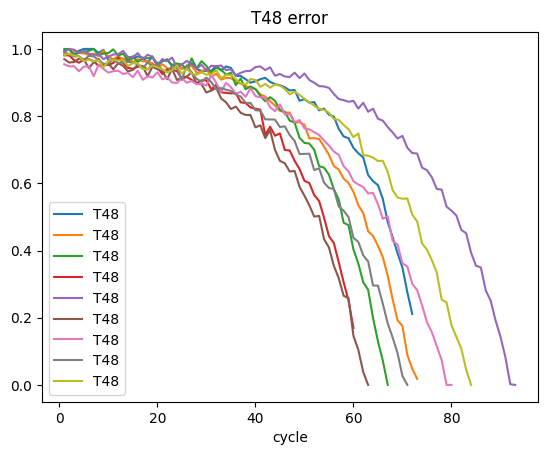

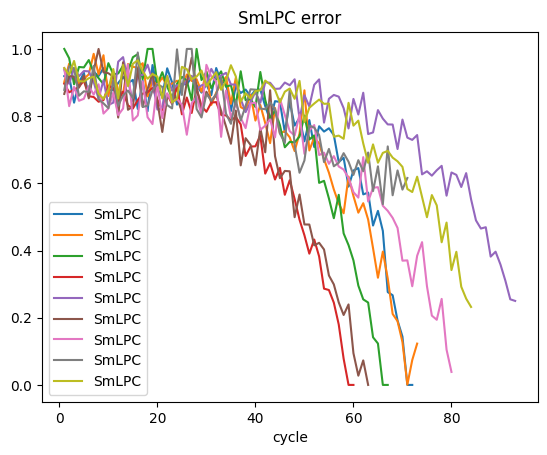

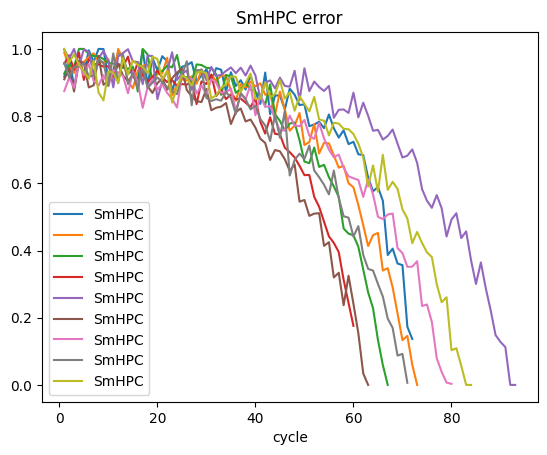

In [16]:
for perf in pipe.get_performances():
    fig, ax = plt.subplots()
    ax.set_title(f"{perf} error")
    df_hi.groupby("unit").plot(x="cycle", y=f'{perf}', ax=ax, legend=True)